In [1]:
import cv2
import numpy as np
import mediapipe as mp
from keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter
import time
import sys
import matplotlib.pyplot as plt # For plotting
import seaborn as sns          # For heatmap visualization

In [2]:
# --- A. CONFIGURATION ---
MODEL_PATH = 'asl_cnn_model.h5' # Ensure this points to your trained model
IMAGE_SIZE = 32 
THRESHOLD_VALUE = 161 # OpenCV threshold (TUNE THIS for your specific lighting)
ASL_LETTERS = 'ABCDEFGHIKLMNOPQRSTUVWXY'
SESSION_DURATION = 5.0 # Seconds to capture data for each sign

In [3]:
# --- B. MODEL & MEDIAPIPE SETUP ---
try:
    model = load_model(MODEL_PATH)
except Exception as e:
    print(f"❌ Error loading model '{MODEL_PATH}'. Ensure training was successful.")
    sys.exit()

In [4]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.7)

--- C. PREPROCESSING FUNCTIONS ---

In [5]:
def preprocess_image(image):
    """Processes the cropped hand image to match the model's training input."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.flip(gray, 1)
    gray = cv2.GaussianBlur(gray, (15, 15), 0)
    
    # Using THRESH_BINARY to get a white hand on a black background (if hand is brighter than BG)
    # If the hand is darker than BG, change to cv2.THRESH_BINARY_INV
    _, thresholded = cv2.threshold(gray, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY) 
    
    resized = cv2.resize(thresholded, (IMAGE_SIZE, IMAGE_SIZE))
    normalized = resized / 255.0
    reshaped = np.reshape(normalized, (1, IMAGE_SIZE, IMAGE_SIZE, 1))
    
    return reshaped, resized

In [6]:
def predict_asl_letter(prediction):
    """Maps the model's prediction index to the ASL character."""
    return ASL_LETTERS[np.argmax(prediction)]

In [7]:
# --- D. PREDICTION AND EVALUATION LOOP ---
def run_predictions(true_label):
    """Captures predictions for 5 seconds and calculates accuracy for the true_label."""
    start_time = time.time()
    y_true = [] 
    y_pred = []
    
    while time.time() - start_time < SESSION_DURATION:
        success, frame = cap.read()
        if not success: break

        frame = cv2.flip(frame, 1)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = hands.process(frame_rgb)

        if result.multi_hand_landmarks:
            
            # --- Hand Cropping Logic (Simplified to use the first detected hand) ---
            h, w, c = frame.shape
            x_min, y_min = w, h
            x_max, y_max = 0, 0
            
            for landmark in result.multi_hand_landmarks[0].landmark:
                x, y = int(landmark.x * w), int(landmark.y * h)
                x_min, y_min = min(x_min, x), min(y_min, y)
                x_max, y_max = max(x_max, x), max(y_max, y)

            margin = 30
            x_min = max(0, x_min - margin)
            y_min = max(0, y_min - margin)
            x_max = min(w, x_max + margin)
            y_max = min(h, y_max + margin)

            hand_image = frame[y_min:y_max, x_min:x_max]
            
            if hand_image.size > 0:
                preprocessed_image, resized_image = preprocess_image(hand_image)

                prediction = model.predict(preprocessed_image, verbose=0)
                asl_letter = predict_asl_letter(prediction)
                confidence = np.max(prediction) * 100
                
                # Store data points for metric calculation
                y_true.append(true_label)
                y_pred.append(asl_letter)

                # Draw UI feedback
                cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                cv2.putText(frame, f'PRED: {asl_letter} ({confidence:.1f}%)', 
                            (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                cv2.imshow('Preprocessed Image', resized_image)

        cv2.putText(frame, f"HOLD: {true_label} | TIME: {SESSION_DURATION - (time.time() - start_time):.1f}s", 
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.imshow('ASL Recognition', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    return y_true, y_pred

In [8]:
# --- E. MAIN EXECUTION ---
cap = cv2.VideoCapture(0)
metrics_per_letter = {}
y_true_total = [] 
y_pred_total = [] 

In [9]:
print("=============================================")
print("ASL REAL-TIME EVALUATION MODE")
print("=============================================")

ASL REAL-TIME EVALUATION MODE


In [10]:
for true_label in ASL_LETTERS:
    print(f"\n👉 Ready for letter: {true_label}. Press 'C' to begin capture.")
    
    # Loop to wait for user input (C or Q)
    while True:
        ret, frame = cap.read()
        if not ret: sys.exit()
        
        frame = cv2.flip(frame, 1)
        cv2.putText(frame, f"Ready: {true_label}. Press 'C' to start 5s test.", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.imshow('ASL Recognition', frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('c'):
            print(f"   Capturing {true_label} for {SESSION_DURATION} seconds.")
            break
        elif key == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            sys.exit()

    # Run the prediction session
    y_true, y_pred = run_predictions(true_label)

    # Calculate metrics after prediction session
    if y_pred:
        accuracy = accuracy_score(y_true, y_pred)
        most_common_label, count = Counter(y_pred).most_common(1)[0]
        
        metrics_per_letter[true_label] = {
            'Accuracy': accuracy,
            'Most Predicted Label': most_common_label,
            'Count': count,
            'Total Frames': len(y_pred)
        }
        
        y_true_total.extend(y_true)
        y_pred_total.extend(y_pred)
        
        print(f'   Result: Accuracy: {accuracy:.2f}, Most Predicted: {most_common_label} ({count} frames)')
        cv2.destroyAllWindows()
        
    else:
        print("   No hand detected during the session.")


👉 Ready for letter: A. Press 'C' to begin capture.
   Capturing A for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 0.97, Most Predicted: A (31 frames)

👉 Ready for letter: B. Press 'C' to begin capture.
   Capturing B for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 1.00, Most Predicted: B (52 frames)

👉 Ready for letter: C. Press 'C' to begin capture.
   Capturing C for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 1.00, Most Predicted: C (52 frames)

👉 Ready for letter: D. Press 'C' to begin capture.
   Capturing D for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 1.00, Most Predicted: D (52 frames)

👉 Ready for letter: E. Press 'C' to begin capture.
   Capturing E for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 1.00, Most Predicted: E (51 frames)

👉 Ready for letter: F. Press 'C' to begin capture.
   Capturing F for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 1.00, Most Predicted: F (51 frames)

👉 Ready for letter: G. Press 'C' to begin capture.
   Capturing G for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 1.00, Most Predicted: G (52 frames)

👉 Ready for letter: H. Press 'C' to begin capture.
   Capturing H for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 1.00, Most Predicted: H (51 frames)

👉 Ready for letter: I. Press 'C' to begin capture.
   Capturing I for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 0.98, Most Predicted: I (51 frames)

👉 Ready for letter: K. Press 'C' to begin capture.
   Capturing K for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 1.00, Most Predicted: K (52 frames)

👉 Ready for letter: L. Press 'C' to begin capture.
   Capturing L for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 1.00, Most Predicted: L (52 frames)

👉 Ready for letter: M. Press 'C' to begin capture.
   Capturing M for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 1.00, Most Predicted: M (50 frames)

👉 Ready for letter: N. Press 'C' to begin capture.
   Capturing N for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 0.29, Most Predicted: M (36 frames)

👉 Ready for letter: O. Press 'C' to begin capture.
   Capturing O for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 1.00, Most Predicted: O (51 frames)

👉 Ready for letter: P. Press 'C' to begin capture.
   Capturing P for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 0.14, Most Predicted: G (41 frames)

👉 Ready for letter: Q. Press 'C' to begin capture.
   Capturing Q for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 1.00, Most Predicted: Q (52 frames)

👉 Ready for letter: R. Press 'C' to begin capture.
   Capturing R for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 1.00, Most Predicted: R (51 frames)

👉 Ready for letter: S. Press 'C' to begin capture.
   Capturing S for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 0.25, Most Predicted: T (37 frames)

👉 Ready for letter: T. Press 'C' to begin capture.
   Capturing T for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 1.00, Most Predicted: T (52 frames)

👉 Ready for letter: U. Press 'C' to begin capture.
   Capturing U for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 0.90, Most Predicted: U (45 frames)

👉 Ready for letter: V. Press 'C' to begin capture.
   Capturing V for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 0.02, Most Predicted: K (51 frames)

👉 Ready for letter: W. Press 'C' to begin capture.
   Capturing W for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 1.00, Most Predicted: W (52 frames)

👉 Ready for letter: X. Press 'C' to begin capture.
   Capturing X for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 1.00, Most Predicted: X (51 frames)

👉 Ready for letter: Y. Press 'C' to begin capture.
   Capturing Y for 5.0 seconds.


c:\Users\HP\asl_detection1\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


   Result: Accuracy: 1.00, Most Predicted: Y (51 frames)




     FINAL OVERALL REAL-TIME ACCURACY: 0.86

Detailed Per-Letter Performance:
Sign A: ACC=0.97 | PRED=A (31/32 frames)
Sign B: ACC=1.00 | PRED=B (52/52 frames)
Sign C: ACC=1.00 | PRED=C (52/52 frames)
Sign D: ACC=1.00 | PRED=D (52/52 frames)
Sign E: ACC=1.00 | PRED=E (51/51 frames)
Sign F: ACC=1.00 | PRED=F (51/51 frames)
Sign G: ACC=1.00 | PRED=G (52/52 frames)
Sign H: ACC=1.00 | PRED=H (51/51 frames)
Sign I: ACC=0.98 | PRED=I (51/52 frames)
Sign K: ACC=1.00 | PRED=K (52/52 frames)
Sign L: ACC=1.00 | PRED=L (52/52 frames)
Sign M: ACC=1.00 | PRED=M (50/50 frames)
Sign N: ACC=0.29 | PRED=M (36/51 frames)
Sign O: ACC=1.00 | PRED=O (51/51 frames)
Sign P: ACC=0.14 | PRED=G (41/51 frames)
Sign Q: ACC=1.00 | PRED=Q (52/52 frames)
Sign R: ACC=1.00 | PRED=R (51/51 frames)
Sign S: ACC=0.25 | PRED=T (37/51 frames)
Sign T: ACC=1.00 | PRED=T (52/52 frames)
Sign U: ACC=0.90 | PRED=U (45/50 frames)
Sign V: ACC=0.02 | PRED=K (51/52 frames)
Sign W: ACC=1.00 | PRED=W (52/52 frames)
Sign X: ACC=1.00 |

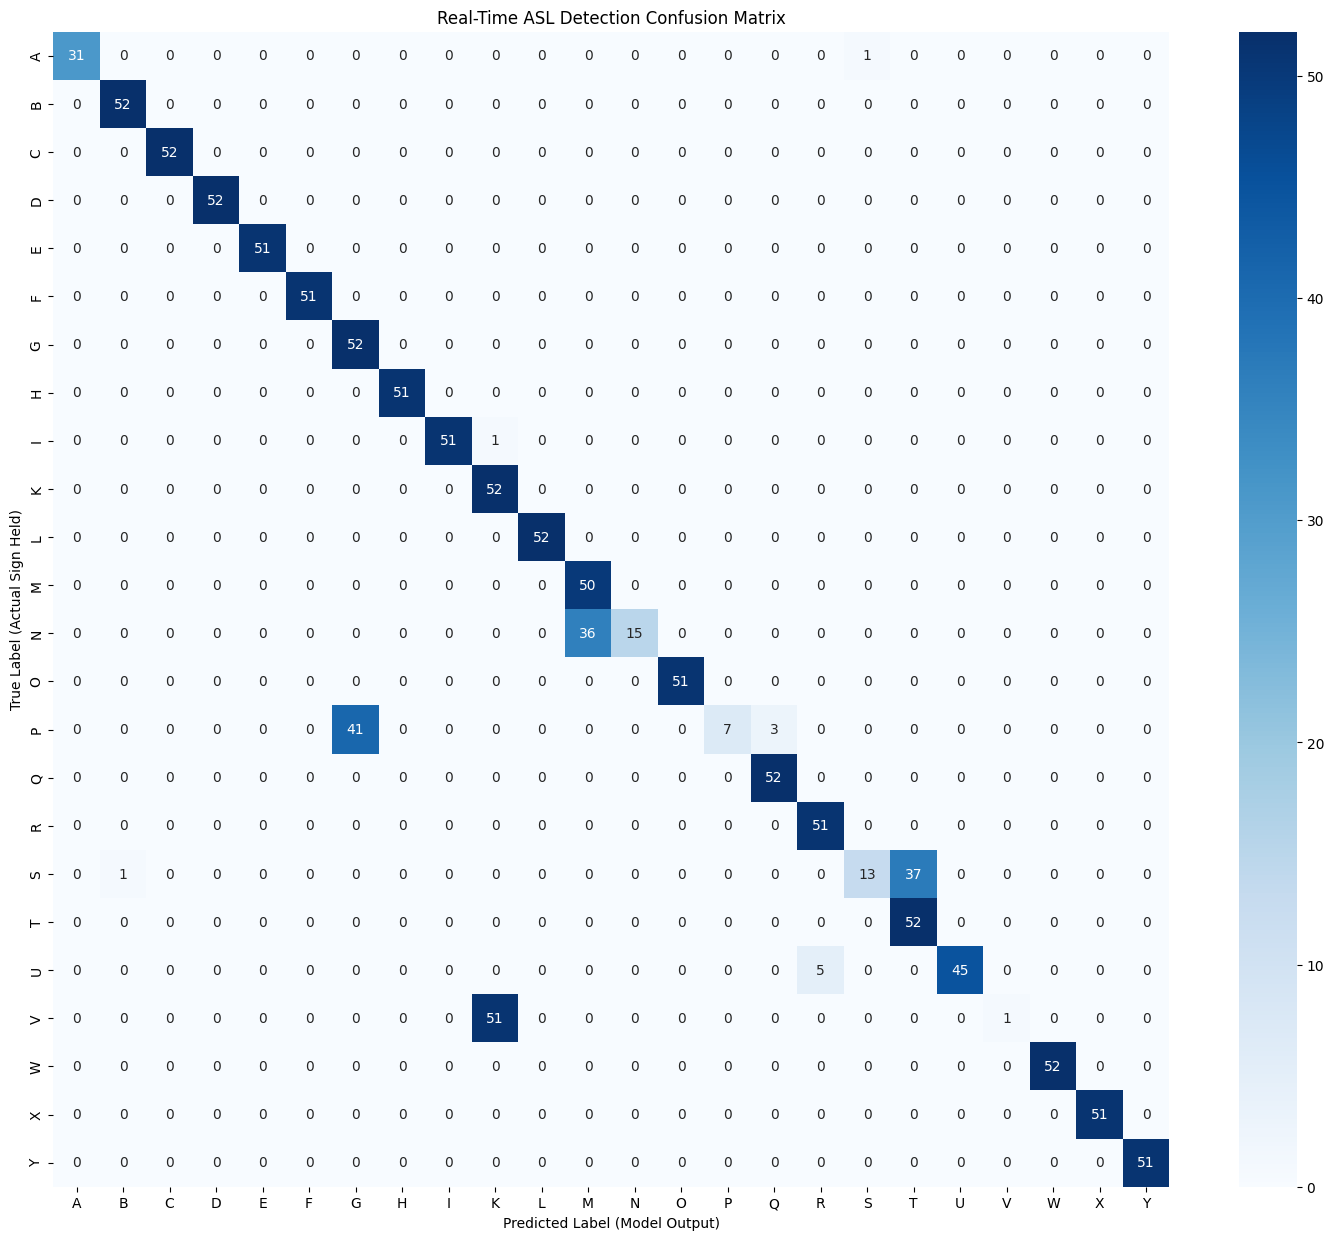

In [11]:
# --- F. FINAL REPORTING ---
if y_true_total:
    final_accuracy = accuracy_score(y_true_total, y_pred_total)
    
    print("\n\n=============================================")
    print(f"     FINAL OVERALL REAL-TIME ACCURACY: {final_accuracy:.2f}")
    print("=============================================")

    print("\nDetailed Per-Letter Performance:")
    for letter, metrics in metrics_per_letter.items():
        print(f'Sign {letter}: ACC={metrics["Accuracy"]:.2f} | PRED={metrics["Most Predicted Label"]} ({metrics["Count"]}/{metrics["Total Frames"]} frames)')
    
    
    # --- G. CONFUSION MATRIX GENERATION AND DISPLAY ---
    print("\n--- Generating Confusion Matrix Plot ---")
    
    labels_list = list(ASL_LETTERS) 
    
    # Calculate the Confusion Matrix
    cm = confusion_matrix(y_true_total, y_pred_total, labels=labels_list)

    # Plot the Matrix
    plt.figure(figsize=(18, 15)) 
    sns.heatmap(
        cm, 
        annot=True,        
        fmt='d',           
        cmap='Blues',      
        xticklabels=labels_list, 
        yticklabels=labels_list 
    )
    plt.title('Real-Time ASL Detection Confusion Matrix')
    plt.ylabel('True Label (Actual Sign Held)')
    plt.xlabel('Predicted Label (Model Output)')
    plt.show()

In [13]:
if not y_true_total:
    print("\nNo full evaluation cycle was completed.")

In [14]:
cap.release()
cv2.destroyAllWindows()